### Loading the libraries

In [188]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import pickle
import datetime as dt
from lifetimes.plotting import *
from lifetimes.utils import *
from lifetimes.estimation import *
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_history_alive
import warnings
warnings.filterwarnings('ignore')

### Reading the data

In [189]:
train_df = pd.read_csv("train-flattened.csv")
print(train_df.shape)
train_df['trafficSource.adContent'].value_counts()

(903653, 55)


Google Merchandise Collection                  5122
Google Online Store                            1245
Display Ad created 3/11/14                      967
Full auto ad IMAGE ONLY                         822
Ad from 12/13/16                                610
Ad from 11/3/16                                 489
Display Ad created 3/11/15                      392
{KeyWord:Google Brand Items}                    251
{KeyWord:Google Merchandise}                    155
Ad from 11/7/16                                 123
First Full Auto Template Test Ad                 87
Google Merchandise                               87
20% discount                                     75
{KeyWord:Google Branded Gear}                    67
{KeyWord:Looking for Google Bags?}               65
Swag with Google Logos                           64
Display Ad created 11/17/14                      50
{KeyWord:Want Google Stickers?}                  42
JD_5a_v1                                         41
{KeyWord:Goo

### EDA and Transformations of Features

### Sneak Peek at the data

In [190]:
train_df.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,...,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,google + online,organic,NaN,google
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,1472822600,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,True,(not provided),organic,NaN,google


### Getting the categorical and numerical columns

In [191]:
cols = train_df.columns
num_cols = train_df._get_numeric_data().columns
factor_cols = list(set(cols) - set(num_cols))

### Getting the count of missing values in the categorical values and plotting the same

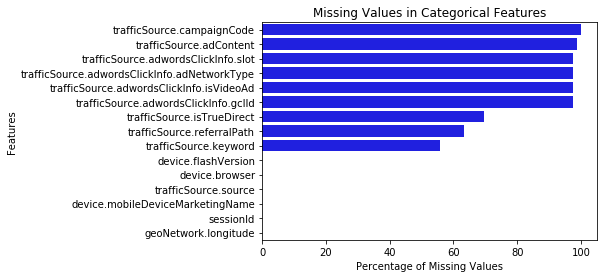

In [192]:
total_test = train_df[factor_cols].isnull().sum().sort_values(ascending=False)
percent = (train_df[factor_cols].isnull().sum()/train_df[factor_cols].isnull().count()).sort_values(ascending=False)*100
data_to_be_removed = pd.concat([total_test, percent], axis=1,join='outer', keys=['Missing Value Count', 'Percentage of Missing Values'])
data_to_be_removed.index.name ='Features'

sns.barplot(y = data_to_be_removed.index[:15],x = data_to_be_removed['Percentage of Missing Values'][:15],color='blue').set_title("Missing Values in Categorical Features")
missing_cols = list(data_to_be_removed[data_to_be_removed['Percentage of Missing Values']>50.0].iloc[:,1].index)

### Getting the count of missing values in the continuous variables and plotting it

Text(0.5,1,'Missing Values in Continuous Features')

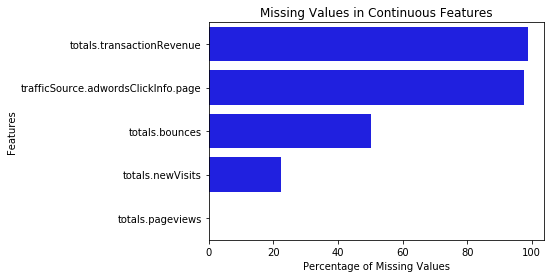

In [193]:
total_test1 = train_df[num_cols].isnull().sum().sort_values(ascending=False)
percent1 = (train_df[num_cols].isnull().sum()/train_df[num_cols].isnull().count()).sort_values(ascending=False)*100
data_to_be_removed1 = pd.concat([total_test1, percent1], axis=1,join='outer', keys=['Missing Value Count', 'Percentage of Missing Values'])
data_to_be_removed1.index.name ='Features'

sns.barplot(y = data_to_be_removed1.index[:5],x = data_to_be_removed1['Percentage of Missing Values'][:5],color='blue').set_title("Missing Values in Continuous Features")

*Note : The feature 'totals.transactionRevenue' is the revenue generated in every session/log in of each user and if it's   missing, it means that no revenue was generated. So, rather than dropping the missing values, we should recode it to 0 in this case*


### Removing Categorical features with just 1 level

In [194]:
single_level_cols = [cols for cols in train_df[factor_cols].columns if train_df[cols].nunique(dropna=False)==1 ]
train_df.drop(single_level_cols,axis=1,inplace=True)
print(train_df.shape)

(903653, 37)


### Exploring the Revenue feature

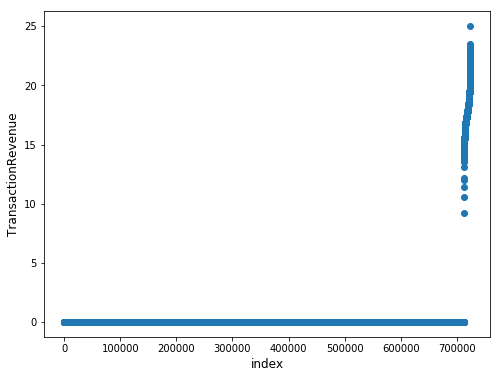

In [195]:
train_df["totals.transactionRevenue"] = train_df["totals.transactionRevenue"].astype('float')
tt = train_df.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()

plt.figure(figsize=(8,6))
plt.scatter(range(tt.shape[0]), np.sort(np.log1p(tt["totals.transactionRevenue"].values)))
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.show()

*Note : We can observe that only a small percentage of the customers actually produce revenue to the business and this aligns with the 80-20 rule*


### Generating our target variable of interest : Flag indicating if a customer is a revenue generating customer or not

In [196]:
group_cols = ['fullVisitorId']
counted = 'totals.transactionRevenue'
agg_name = 'totals.transactionRevenue_sum'
gp = train_df[group_cols+[counted]].groupby(group_cols)[counted].sum().reset_index().rename(columns={counted:agg_name})

gp['Revenue_Generating_Flag'] = np.where(gp['totals.transactionRevenue_sum']>0,1,0)
cols = ['fullVisitorId','Revenue_Generating_Flag']

train_df1 = pd.merge(train_df,gp[cols],on='fullVisitorId',how='inner')


## Baseline Modelling

In [197]:
excluded_features = [
    'date', 'fullVisitorId', 'sessionId', 'totals.transactionRevenue', 
    'visitId', 'visitStartTime', 'vis_date', 'nb_sessions', 'max_visits'
]

excluded_features = excluded_features + missing_cols

categorical_features = [
    i for i in train_df1.columns
    if (i not in excluded_features) & (train_df1[i].dtype == 'object')
]

### Factorizing the categorical features for baseline model

In [198]:
train_df1_baseline = train_df1[:]
for f in categorical_features:
    train_df1_baseline[f], indexer = pd.factorize(train_df1_baseline[f])
req_features = [i for i in train_df1.columns if i not in excluded_features]
train_df1_baseline = train_df1_baseline[req_features + ['fullVisitorId']].groupby('fullVisitorId').mean()

### Splitting the data to create a test data to evaluate the baseline models

In [199]:
y = train_df1_baseline['Revenue_Generating_Flag']
X = train_df1_baseline.loc[:, train_df1_baseline.columns != 'Revenue_Generating_Flag']

del train_df1_baseline['Revenue_Generating_Flag']
train_df1_baseline = train_df1_baseline.reset_index()

train, test, y_train, y_test = train_test_split(X, y,stratify=y,test_size=0.3,random_state=20)

### Running baseline models

#### Logistic Regression

In [200]:
train.fillna(train.median(),inplace=True)
test.fillna(test.median(),inplace=True)


lr = LogisticRegression(random_state=20)
lr.fit(train,y_train)
test_glm_baseline = lr.predict_proba(test)[:,1]
print("The AUC Score is {}".format(roc_auc_score(y_test, test_glm_baseline)))
print("\n")
print('The confusion matrix :')
avg1 = np.where(test_glm_baseline<0.5,0,1)
df_confusion = pd.crosstab(y_test, avg1)
print(df_confusion)
print("\n")
print("The recall score is {}".format(383/(383+2651)))

The AUC Score is 0.963734574564873


The confusion matrix :
col_0                         0    1
Revenue_Generating_Flag             
0                        213647  460
1                          2651  383


The recall score is 0.12623599208965064


#### Random Foresst

In [201]:
rf = RandomForestClassifier(random_state=20)
rf.fit(train,y_train)
test_rf_baseline = rf.predict_proba(test)[:,1]
print("The AUC Score is {}".format(roc_auc_score(y_test, test_rf_baseline)))
print("\n")
print('The confusion matrix :')
avg1 = np.where(test_rf_baseline<0.5,0,1)
df_confusion = pd.crosstab(y_test, avg1)
print(df_confusion)
print("\n")
print("The recall score is {}".format(1096/(1096+1938)))

The AUC Score is 0.9107102239330005


The confusion matrix :
col_0                         0     1
Revenue_Generating_Flag              
0                        212930  1177
1                          1938  1096


The recall score is 0.3612392880685564


#### Gradient Boosting

In [202]:
gbm = GradientBoostingClassifier(random_state=20)
gbm.fit(train,y_train)
test_gbm_baseline = gbm.predict_proba(test)[:,1]
print("The AUC Score is {}".format(roc_auc_score(y_test, test_gbm_baseline)))
print("\n")
print('The confusion matrix :')
avg1 = np.where(test_gbm_baseline<0.5,0,1)
df_confusion = pd.crosstab(y_test, avg1)
print(df_confusion)
print("\n")
print("The recall score is {}".format(920/(920+2114)))

The AUC Score is 0.9859941370624086


The confusion matrix :
col_0                         0    1
Revenue_Generating_Flag             
0                        213471  636
1                          2114  920


The recall score is 0.3032300593276203


## Feature Engineering

### Data Wrangling / Cleaning

In [203]:
class Wrangler:
    
    def browser_wrangling(self,x):
        top_10_browsers = ['chrome','safari','firefox','internet explorer','edge','android webview','safari (in-app)','opera mini','opera','uc browser']
       
        if x in top_10_browsers:
            return x.lower()
    
        
        elif '(not set)' in x:
            return x
    
        else:
            return 'others'

        
    def source_wrangling(self,x):
        if  ('google' in x):
            return 'google'
        elif  ('youtube' in x):
            return 'youtube'
        elif 'yahoo' in x:
            return 'yahoo'
        elif 'facebook' in x:
            return 'facebook'
        elif 'reddit' in x:
            return 'reddit'
        elif 'bing' in x:
            return 'bing'
        elif 'quora' in x:
            return 'quora'
        elif 'outlook' in x:
            return 'outlook'
        elif 'linkedin' in x:
            return 'linkedin'
        elif 'twitter' in x:
            return 'twitter'
        elif '(not set)' in x or 'nan' in x:
            return x
        else:
            return 'others'
        
    def device_os_wrangling(self,x):
        top_10_device_os = ['windows','macintosh','andorid','ios', 'linux','chrome os','windows phone']
       
        if x in top_10_device_os:
            return x.lower()

        #elif x in mobile_browsers:
         #   return 'mobile browser'

        elif '(not set)' in x:
            return x

        else:
            return 'others'
        
    def nw_domain_wrangling(self,x):
        tt = x['geoNetwork.networkDomain'].value_counts()
        tt = pd.DataFrame(tt)
        
        tt['column_names'] = tt.index
        cols = ['values','geoNetwork.networkDomain']
        tt.columns  = cols
     
        x = pd.merge(x,tt,on='geoNetwork.networkDomain',how='left')
        x['geoNetwork.networkDomain'] = np.where(x['values']<=20,'Others',x['geoNetwork.networkDomain'])
        del x['values']
        x['geoNetwork.networkDomain'].value_counts()
        return x
    
    def plots(self,x):
        bar1x=[]
        bar1y=[]
        for i in range(len(x)):
    
            bar1x.append(x.index[i])
            bar1y.append(x[i])

        plt.figure(figsize=(8, 10))
        g=sns.barplot(x=bar1y, y=bar1x)
        for i in range(len(bar1y)):
            g.text(x = bar1y[i] , y = i, s = bar1y[i], size = 10)


In [204]:
wrang = Wrangler()

Plot of top 10 device browsers before transformation
Plot of device browsers after transformation


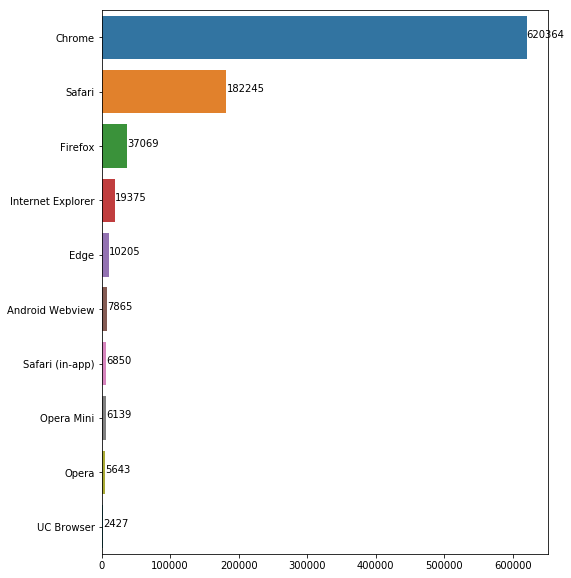

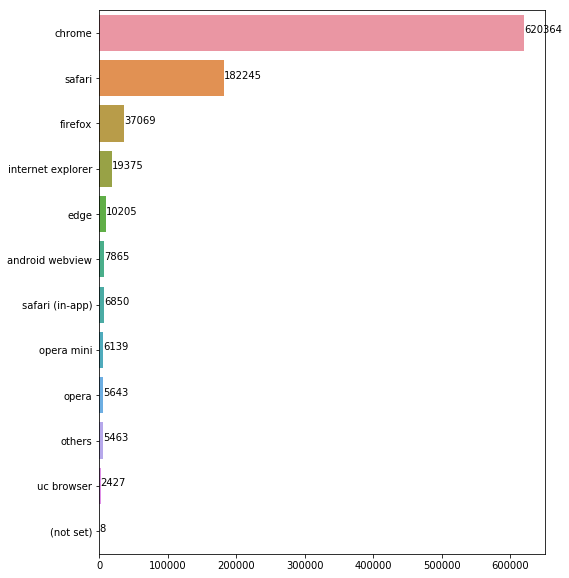

In [205]:
x=train_df1['device.browser'].value_counts()
print("Plot of top 10 device browsers before transformation")
wrang.plots(x[:10])
train_df1['device.browser'] = train_df1['device.browser'].map(lambda x:wrang.browser_wrangling(str(x).lower())).astype('str')
x=train_df1['device.browser'].value_counts()
print("Plot of device browsers after transformation")
wrang.plots(x)


Plot of top 10 Sources before transformation
Plot of Sources after transformation


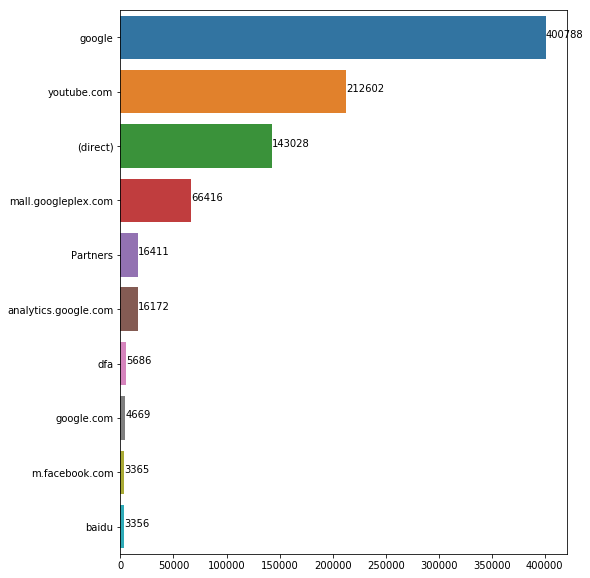

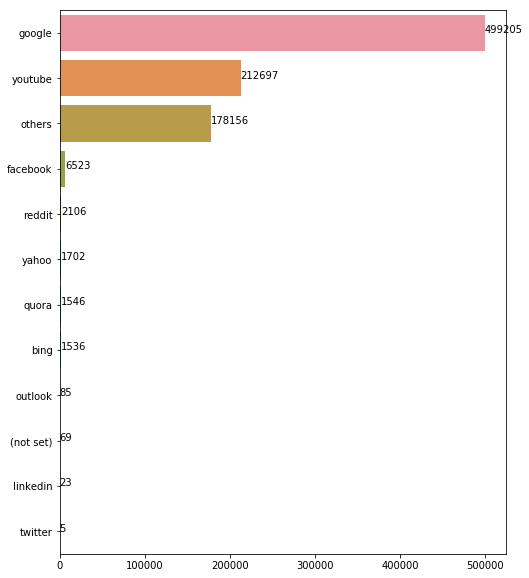

In [206]:
x=train_df1['trafficSource.source'].value_counts()
print("Plot of top 10 Sources before transformation")
wrang.plots(x[:10])
train_df1['trafficSource.source'] = train_df1['trafficSource.source'].map(lambda x:wrang.source_wrangling(str(x).lower())).astype('str')
x=train_df1['trafficSource.source'].value_counts()
print("Plot of Sources after transformation")
wrang.plots(x)


Plot of top 10 Operating Systems before transformation
Plot of Operating Systems after transformation


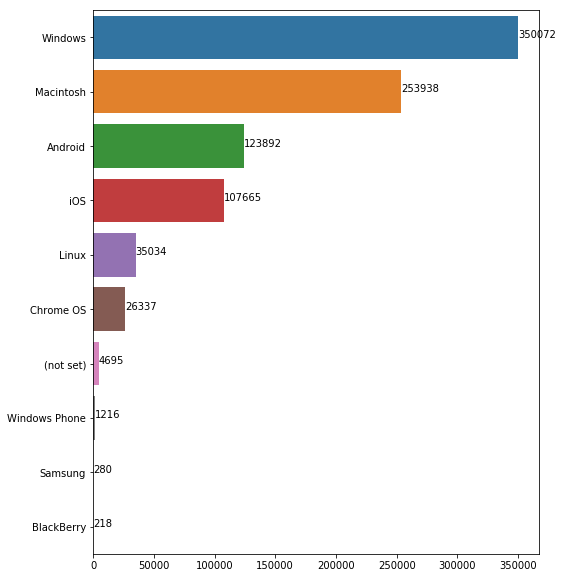

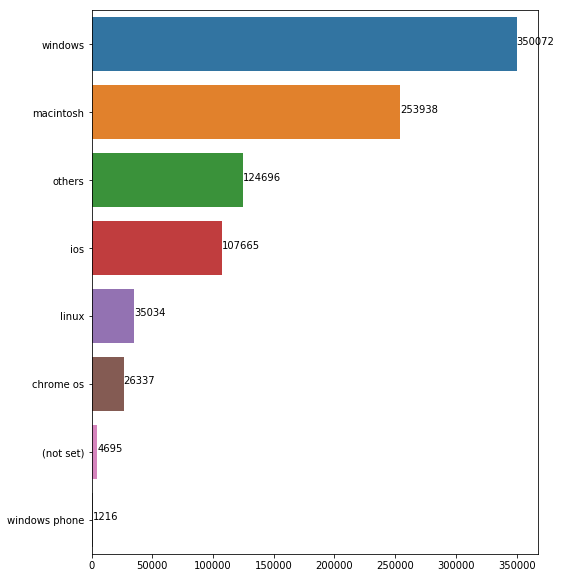

In [207]:
print("Plot of top 10 Operating Systems before transformation")
x=train_df1['device.operatingSystem'].value_counts()
wrang.plots(x[:10])
train_df1['device.operatingSystem'] = train_df1['device.operatingSystem'].map(lambda x:wrang.device_os_wrangling(str(x).lower())).astype('str')
x=train_df1['device.operatingSystem'].value_counts()
print("Plot of Operating Systems after transformation")
wrang.plots(x)

Plot of top 10 Network Domains before transformation
Plot of Network Domains after transformation


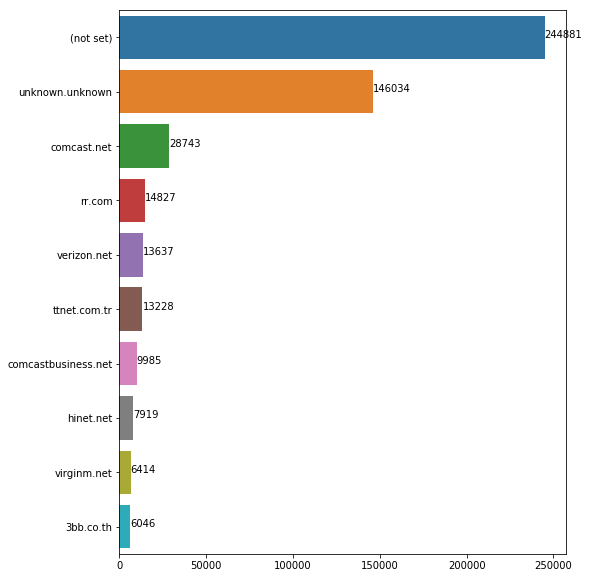

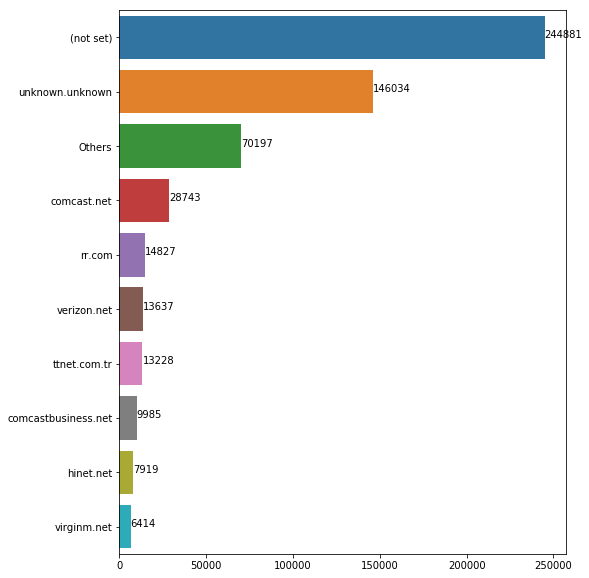

In [208]:
x=train_df1['geoNetwork.networkDomain'].value_counts()
print("Plot of top 10 Network Domains before transformation")
wrang.plots(x[:10])
train_df1 = wrang.nw_domain_wrangling(train_df1)
x=train_df1['geoNetwork.networkDomain'].value_counts()
print("Plot of Network Domains after transformation")
wrang.plots(x[:10])



### Creating New Features

In [209]:
train_df1['source.country'] = train_df1['trafficSource.source'] + '_' + train_df1['geoNetwork.country']
train_df1['campaign.medium'] = train_df1['trafficSource.campaign'] + '_' + train_df1['trafficSource.medium']
train_df1['browser.category'] = train_df1['device.browser'] + '_' + train_df1['device.deviceCategory']
train_df1['browser.os'] = train_df1['device.browser'] + '_' + train_df1['device.operatingSystem']

In [210]:
train_df1['device_deviceCategory_channelGrouping'] = train_df1['device.deviceCategory'] + "_" + train_df1['channelGrouping']
train_df1['channelGrouping_browser'] = train_df1['device.browser'] + "_" + train_df1['channelGrouping']
train_df1['channelGrouping_OS'] = train_df1['device.operatingSystem'] + "_" + train_df1['channelGrouping']
train_df1['content.source'] = train_df1['trafficSource.adContent'] + "_" + train_df1['source.country']
train_df1['medium.source'] = train_df1['trafficSource.medium'] + "_" + train_df1['source.country']

### Removing unwanted columns/features

In [211]:
excluded_features = [
    'date', 'fullVisitorId', 'sessionId', 'totals.transactionRevenue', 
    'visitId', 'visitStartTime', 'vis_date', 'nb_sessions', 'max_visits'
]

excluded_features = excluded_features + missing_cols

categorical_features = [
    i for i in train_df1.columns
    if (i not in excluded_features) & (train_df1[i].dtype == 'object')
]

### Factorizing the categorical features

In [212]:
for f in categorical_features:
    train_df1[f], indexer = pd.factorize(train_df1[f])
req_features = [i for i in train_df1.columns if i not in excluded_features]
train_df2 = train_df1[req_features + ['fullVisitorId']].groupby('fullVisitorId').mean()

In [213]:
train_df2['Revenue_Generating_Flag'].value_counts()

0    713689
1     10114
Name: Revenue_Generating_Flag, dtype: int64

*Note : We can see that only 1.4% of the customers are Revenue Generating Customers*

In [214]:
y = train_df2['Revenue_Generating_Flag']
X = train_df2.loc[:, train_df2.columns != 'Revenue_Generating_Flag']

del train_df2['Revenue_Generating_Flag']
train_df2 = train_df2.reset_index()

train, test, y_train, y_test = train_test_split(X, y,stratify=y,test_size=0.3,random_state=20)

### Checking the distribution of the target variable in train and test

In [215]:
print(y_test.value_counts())
y_train.value_counts()

0    214107
1      3034
Name: Revenue_Generating_Flag, dtype: int64


0    499582
1      7080
Name: Revenue_Generating_Flag, dtype: int64

In [216]:
3034/(3034+214107)

0.013972487922594075

In [217]:
7080/(7080+499582)

0.013973812916697918

*We can observe that the data is highly imbalanced and we will proceed to perform SMOTE to accomodate the target variable imbalance on the training data*

### Performing SMOTE

In [218]:
train.fillna(train.median(),inplace=True)
sm = SMOTE(random_state=12, ratio = 0.2)
x_train_res, y_train_res = sm.fit_sample(train, y_train)
x_train_res = pd.DataFrame(x_train_res)
x_train_res.columns = train.columns
y_train_res = pd.DataFrame(y_train_res)


In [219]:
print(train.shape)
print(y_train.shape)
print(x_train_res.shape)
print(y_train_res.shape)

(506662, 31)
(506662,)
(599498, 31)
(599498, 1)


In [220]:
print(y_train_res[0].value_counts())

0    499582
1     99916
Name: 0, dtype: int64


In [221]:
99916/(99916+499582)

0.16666611064590708

*Because of SMOTE we can see that the Revenue Generating customers are now incresed to ~17%*

### Spliting the Training Data into 5 Folds 

In [222]:
skf = StratifiedKFold(n_splits=5)

In [223]:
for a,b in skf.split(x_train_res,y_train_res):
    print(y_train_res[0].iloc[a].value_counts())
    print(y_train_res[0].iloc[b].value_counts())

0    399665
1     79932
Name: 0, dtype: int64
0    99917
1    19984
Name: 0, dtype: int64
0    399665
1     79933
Name: 0, dtype: int64
0    99917
1    19983
Name: 0, dtype: int64
0    399666
1     79933
Name: 0, dtype: int64
0    99916
1    19983
Name: 0, dtype: int64
0    399666
1     79933
Name: 0, dtype: int64
0    99916
1    19983
Name: 0, dtype: int64
0    399666
1     79933
Name: 0, dtype: int64
0    99916
1    19983
Name: 0, dtype: int64


In [224]:
79932/(79932+399665)

0.1666649290967208

In [225]:
19984/(19984+99917)

0.16667083677367162

*We have used stratified Kfold we ensure equal distribution of the target variable*

### Tuning Model Hyperparameters

In [226]:
class tune:
    def logreg(self,x_train_res,y_train_res):
        lambda_vals = [0.001,0.01,0.1,1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000,10000000000]
        #lambda_vals = [1000,10000,100000,1000000,10000000,100000000,1000000000,10000000000]
        lambda_vals1 = np.reciprocal(lambda_vals)
        acc_table = pd.DataFrame(columns = ['lambda_vals','CV_AUC'])
        acc_table['lambda_vals'] = lambda_vals

        j=0
        for i in lambda_vals1:
            avg = 0
            for a,b in skf.split(x_train_res,y_train_res):
                trn_x, trn_y = x_train_res.iloc[a], y_train_res[0].iloc[a]
                val_x, val_y = x_train_res.iloc[b], y_train_res[0].iloc[b]
                lr = LogisticRegression(penalty = 'l2', C = i,random_state=20)
                lr.fit(trn_x,trn_y)
                test_pred = lr.predict_proba(val_x)[:,1]
                avg+=roc_auc_score(val_y, test_pred)

            avg1 = avg/5.0
            acc_table.iloc[j,1] = avg1
            j = j+1

        return acc_table
    
    def rftune(self,x_train_res,y_train_res):
        param_grid = { 
            'n_estimators': [300,400,500],
            'max_depth' : [6,7,8]
        }
        rfc = RandomForestClassifier(random_state=20)
        CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 3)
        CV_rfc.fit(x_train_res, y_train_res)
        return CV_rfc.best_params_
      
'''   
    def gbmtune(self,x_train_res,y_train_res):
        parameters = {
      "learning_rate": [0.05, 0.1, 0.25],
     # "learning_rate": [0.2],
      #"min_samples_split": np.linspace(0.1, 0.5, 12),
    #  "min_samples_leaf": [0.1,0.2,0.3,0.4,0.5], #np.linspace(0.1, 0.5, 12),
      "max_depth":[5,6,7,8],
      #"max_depth":[8],
      #"max_features":["log2","sqrt"],
      #"scoring": ["roc_auc"],
     #"subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
      "n_estimators":[200,300,400,500]
      #"n_estimators":[500]
      }

        cv_gbm = GridSearchCV(GradientBoostingClassifier(), parameters, cv=3)
        cv_gbm.fit(x_train_res,y_train_res)
        return cv_gbm.best_params_
'''

tuner=tune()
acc_table=tuner.logreg(x_train_res,y_train_res)
print(acc_table)

best_params_rf = tuner.rftune(x_train_res,y_train_res)
print(best_params_rf)
#tuner=tune()
#best_params_gbm = tuner.gbmtune(x_train_res,y_train_res)
#print(best_params_gbm)

     lambda_vals    CV_AUC
0   1.000000e-03  0.978866
1   1.000000e-02  0.978874
2   1.000000e-01  0.978873
3   1.000000e+00  0.978877
4   1.000000e+01  0.978884
5   1.000000e+02  0.978945
6   1.000000e+03   0.97826
7   1.000000e+04  0.971253
8   1.000000e+05  0.952657
9   1.000000e+06  0.927699
10  1.000000e+07  0.880474
11  1.000000e+08  0.769419
12  1.000000e+09  0.678995
13  1.000000e+10   0.66227
{'max_depth': 8, 'n_estimators': 400}


*Note: Hyper parameter tuning of GBM took a very long time, hence a default gradient boosting model was implemented *

### Building Logistic Regression Model on the obtained Hyperparameter

#### Keeping aside 20% of the train data as validation which can be used for ensemble and stacking later

In [41]:
#x_train_res = train
#y_train_res = y_train
x1_train, x1_test, y1_train, y1_test = train_test_split(x_train_res,y_train_res,
                                                stratify=y_train_res, 
                                                test_size=0.2,random_state=20)

val_table = pd.DataFrame(columns = ['Actuals','glm','rf','gbm'])
val_table['Actuals'] = y1_test[0]
test_table = pd.DataFrame(columns = ['Actuals','glm','rf','gbm'])
test_table['Actuals'] = y_test

#train_features = [_f for _f in x_train_res.columns if _f not in excluded_features]
x1_train.fillna(x1_train.median(),inplace=True)
x1_test.fillna(x1_test.median(),inplace=True)
test.fillna(test.median(),inplace=True)

In [40]:
lr = LogisticRegression(penalty = 'l2', C = 0.01,random_state=20)
lr.fit(x1_train,y1_train)
filename = 'phase1_glm.sav'
pickle.dump(lr, open(filename, 'wb'))

#### Making Predictions on non-synthesized train data also (For Phase 2)

In [42]:
filename = 'phase1_glm.sav'
lr = pickle.load(open(filename, 'rb'))

val_table['glm'] = lr.predict_proba(x1_test)[:,1]
test_table['glm'] = lr.predict_proba(test)[:,1]
train['glm'] = lr.predict_proba(train)[:,1]

##### Checking the distribution of the probabilities across the Validation sets

In [43]:
val_table['glm'].describe()

count    1.199000e+05
mean     1.672733e-01
std      3.021289e-01
min      1.878409e-08
25%      8.778786e-04
50%      1.181166e-02
75%      1.261003e-01
max      1.000000e+00
Name: glm, dtype: float64

#### Getting the AUC value for the validation for the tuned Logistic Regression Model

In [44]:
print(roc_auc_score(val_table['Actuals'], val_table['glm']))
avg1 = np.where(val_table['glm']<0.4,0,1)
#print(avg)
df_confusion = pd.crosstab(val_table['Actuals'], avg1)
df_confusion

0.9788792392726747


col_0,0,1
Actuals,,
0,96222,3695
1,2635,17348


In [45]:
print(roc_auc_score(val_table['Actuals'], val_table['glm']))
avg1 = np.where(val_table['glm']<0.5,0,1)
#print(avg)
df_confusion = pd.crosstab(val_table['Actuals'], avg1)
df_confusion

0.9788792392726747


col_0,0,1
Actuals,,
0,97044,2873
1,3985,15998


In [46]:
print(roc_auc_score(val_table['Actuals'], val_table['glm']))
avg1 = np.where(val_table['glm']<0.6,0,1)
#print(avg)
df_confusion = pd.crosstab(val_table['Actuals'], avg1)
df_confusion

0.9788792392726747


col_0,0,1
Actuals,,
0,97668,2249
1,5754,14229


#### Predicting on the hold-out Test Data using the Tuned Model

In [47]:
print(roc_auc_score(test_table['Actuals'], test_table['glm']))
avg1 = np.where(test_table['glm']<0.4,0,1)
#print(avg)
df_confusion = pd.crosstab(test_table['Actuals'], avg1)
df_confusion

0.975404181330253


col_0,0,1
Actuals,,
0,206096,8011
1,491,2543


In [48]:
2543/(2543+491)

0.8381674357284113

### We would be more interested in the recall value of the predictions because in this case no. of revenue generating customers will be very low compared to the non revenue generating customers cases and sometime a revenue generating customer will be predicted as non profitable. So, recall will give us a sense of only profitable customers.

In [49]:
2543/(2543+491)

0.8381674357284113

#### We observe a ~84% recall score on the test set for the tuned Logistic Regression

### Building Random Forest Model on the obtained Hyperparameter

In [50]:
x1_train, x1_test, y1_train, y1_test = train_test_split(x_train_res,y_train_res,
                                                stratify=y_train_res, 
                                                test_size=0.2,random_state=20)

x1_train.fillna(x1_train.median(),inplace=True)
x1_test.fillna(x1_test.median(),inplace=True)
test.fillna(test.median(),inplace=True)

In [93]:
clf_rf = RandomForestClassifier(n_estimators=400,max_depth=8,random_state=20)
clf_rf.fit(x1_train, y1_train)
filename = 'phase1_rf.sav'
pickle.dump(clf_rf, open(filename, 'wb'))

In [51]:
filename = 'phase1_rf.sav'
clf_rf = pickle.load(open(filename, 'rb'))
val_table['rf'] = clf_rf.predict_proba(x1_test)[:,1]
test_table['rf'] = clf_rf.predict_proba(test)[:,1]

#### Predicting on non-synthesized train data (For Phase 2)

In [52]:
train['rf'] = clf_rf.predict_proba(train.loc[:, train.columns != 'glm'])[:,1]

In [53]:
print(roc_auc_score(val_table['Actuals'], val_table['rf']))
avg1 = np.where(val_table['rf']<0.4,0,1)
#print(avg)
df_confusion = pd.crosstab(val_table['Actuals'], avg1)
df_confusion

0.9932529091474404


col_0,0,1
Actuals,,
0,96689,3228
1,553,19430


In [54]:
print(roc_auc_score(val_table['Actuals'], val_table['rf']))
avg1 = np.where(val_table['rf']<0.5,0,1)
#print(avg)
df_confusion = pd.crosstab(val_table['Actuals'], avg1)
df_confusion

0.9932529091474404


col_0,0,1
Actuals,,
0,97365,2552
1,984,18999


In [55]:
print(roc_auc_score(val_table['Actuals'], val_table['rf']))
avg1 = np.where(val_table['rf']<0.6,0,1)
#print(avg)
df_confusion = pd.crosstab(val_table['Actuals'], avg1)
df_confusion

0.9932529091474404


col_0,0,1
Actuals,,
0,98060,1857
1,1915,18068


In [56]:
print(roc_auc_score(test_table['Actuals'],test_table['rf']))
avg1 = np.where(test_table['rf']<0.4,0,1)
#print(avg)
df_confusion = pd.crosstab(test_table['Actuals'], avg1)
df_confusion

0.9856292713493301


col_0,0,1
Actuals,,
0,207153,6954
1,348,2686


In [58]:
2686/(2686+348)

0.8852999340804218

### Loss of Customers Percentage

In [103]:
348/(348+2686)

0.11470006591957811

*Note: We have failed to capture only 11.5% of customers who are actually revenue generating*

###  Gradient Boosting

In [59]:
x1_train, x1_test, y1_train, y1_test = train_test_split(x_train_res,y_train_res,
                                                stratify=y_train_res, 
                                                test_size=0.2,random_state=20)

x1_train.fillna(x1_train.median(),inplace=True)
x1_test.fillna(x1_test.median(),inplace=True)
test.fillna(test.median(),inplace=True)

In [119]:
cf_gb = GradientBoostingClassifier(random_state=20)
cf_gb.fit(x1_train, y1_train)
filename = 'phase1_gbm.sav'
pickle.dump(cf_gb, open(filename, 'wb'))

In [60]:
filename = 'phase1_gbm.sav'
cf_gb = pickle.load(open(filename, 'rb'))

val_table['gbm'] = cf_gb.predict_proba(x1_test)[:,1]
test_table['gbm'] = cf_gb.predict_proba(test)[:,1]

#### Predicting on non-synthesized train data (For Phase 2)

In [61]:
bb = ['glm','rf','gbm']
bb1 = [f for f in train.columns if f not in bb]
train['gbm'] = cf_gb.predict_proba(train.loc[:, bb1])[:,1]

In [62]:
print(roc_auc_score(val_table['Actuals'], val_table['gbm']))
avg1 = np.where(val_table['gbm']<0.4,0,1)
df_confusion = pd.crosstab(val_table['Actuals'], avg1)
df_confusion

0.9956987281478357


col_0,0,1
Actuals,,
0,97472,2445
1,762,19221


In [63]:
print(roc_auc_score(val_table['Actuals'], val_table['gbm']))
avg1 = np.where(val_table['gbm']<0.5,0,1)
df_confusion = pd.crosstab(val_table['Actuals'], avg1)
df_confusion

0.9956987281478357


col_0,0,1
Actuals,,
0,97919,1998
1,1169,18814


In [64]:
print(roc_auc_score(val_table['Actuals'], val_table['gbm']))
avg1 = np.where(val_table['gbm']<0.6,0,1)
df_confusion = pd.crosstab(val_table['Actuals'], avg1)
df_confusion

0.9956987281478357


col_0,0,1
Actuals,,
0,98319,1598
1,1633,18350


In [65]:
print(roc_auc_score(test_table['Actuals'], test_table['gbm']))
avg1 = np.where(test_table['gbm']<0.4,0,1)
df_confusion = pd.crosstab(test_table['Actuals'], avg1)
df_confusion

0.9862067130543675


col_0,0,1
Actuals,,
0,208715,5392
1,504,2530


In [66]:
2530/(2530+504)

0.8338826631509558

### Taking ensemble to verify if we can consider all the 3 models (or) proceed with the best model (Random Forest)

In [67]:
ensemble = (test_table['gbm'] + test_table['rf'] + test_table['glm'])/3
print(roc_auc_score(test_table['Actuals'], ensemble))
avg1 = np.where(ensemble<0.4,0,1)
df_confusion = pd.crosstab(test_table['Actuals'], avg1)
df_confusion

0.9863452404737324


col_0,0,1
Actuals,,
0,207594,6513
1,361,2673


In [68]:
2673/(2673+361)

0.8810151615029663

*Note: Since random forest on it's own gives a better result on the test data when compared to ensemble of all the 3 models, we will proceed with Random Forest predictions for the next business case*

### Saving the phase 1 results

In [69]:
result1 = pd.DataFrame(columns = ['fullVisitorId','Actuals','Predicted'])
result1['Actuals'] = y_test
avg = np.where(test_table['rf']<0.4,0,1)
result1['Predicted'] = avg
result1['fullVisitorId'] = test.index
result1.to_csv("phase1_results.csv",index=False)

## Phase 2 : Predicting the revenue generated by the identified customers

#### Appending the revenue generated

In [70]:
train_reg = train[:]
test_reg = test[:]
train_reg['fullVisitorId'] = train_reg.index
test_reg['fullVisitorId'] = test_reg.index
cols_merge = ['fullVisitorId','totals.transactionRevenue_sum']
train_reg = pd.merge(train_reg,gp[cols_merge],on='fullVisitorId',how='inner')
test_reg = pd.merge(test_reg,gp[cols_merge],on='fullVisitorId',how='inner')
#train_reg['fullVisitorId'],test_reg['fullVisitorId']

In [71]:
test_reg.index = test_table.index
test_reg['glm'] = test_table['glm']
test_reg['rf'] = test_table['rf']

#### Converting probabilities to binary classes

In [72]:
train_reg['glm'] = np.where(train_reg['glm']<0.4,0,1)
train_reg['rf'] = np.where(train_reg['rf']<0.4,0,1)

test_reg['glm'] = np.where(test_reg['glm']<0.4,0,1)
test_reg['rf'] = np.where(test_reg['rf']<0.4,0,1)

### Loss Percentage from our business case 1 predictions

In [73]:
s1 = sum(test_reg[(test_reg.rf==0) & (test_reg['totals.transactionRevenue_sum']!=0)]['totals.transactionRevenue_sum'])
s2 = sum(test_reg[(test_reg.rf==1) & (test_reg['totals.transactionRevenue_sum']!=0)]['totals.transactionRevenue_sum'])
print((s1/(s1+s2))*100)

7.087355480387488


*Note : Phase 1 model resulted in a loss of approximately 7% of the total revenue. *

In [74]:
train_reg_final = train_reg
test_reg_final = test_reg

### Getting transaction level data for the identified customers

In [75]:
excluded_features = [
    'fullVisitorId', 'sessionId', 'totals.transactionRevenue', 
    'visitId', 'vis_date', 'nb_sessions', 'max_visits'
]
excluded_features = excluded_features + missing_cols

req_features = [i for i in train_df1.columns if i not in excluded_features]
req_features.append('totals.transactionRevenue')
req_features.append('fullVisitorId')
train_df1_copy = train_df1[req_features]
train_df1_copy["totals.transactionRevenue"].fillna(0, inplace=True)
#train_df1_copy.fillna(train_df1_copy.mean())
#train_df1_copy.fil(train_df1_copy.mean())
#train_df1_copy['fullVisitorId'] = train_df1.index
train_id_list = list((train_reg_final.fullVisitorId))
train_trans_reg = train_df1_copy.loc[train_df1_copy['fullVisitorId'].isin(train_id_list)]

test_id_list = list((test_reg_final.fullVisitorId))
test_trans_reg = train_df1_copy.loc[train_df1_copy['fullVisitorId'].isin(test_id_list)]



print(train_trans_reg.shape)
print(test_trans_reg.shape)

(632335, 36)
(271318, 36)


In [76]:
cols_join = ['fullVisitorId','glm','rf']
train_trans_reg = pd.merge(train_trans_reg,train_reg_final[cols_join],on='fullVisitorId',how='inner')
test_trans_reg = pd.merge(test_trans_reg,test_reg_final[cols_join],on='fullVisitorId',how='inner')

print(train_trans_reg.shape)
print(test_trans_reg.shape)

(632335, 38)
(271318, 38)


#### Creating features such as day of the week, hour of the day and day of the month to capture the trend and seasonality in the transaction level data

In [77]:
train_trans_reg['date_of_visit'] = pd.to_datetime(train_trans_reg['visitStartTime'], unit='s')
train_trans_reg['day_of_the_week'] = train_trans_reg['date_of_visit'].dt.dayofweek
train_trans_reg['hour_of_the_day'] = train_trans_reg['date_of_visit'].dt.hour
train_trans_reg['day_of_the_month'] = train_trans_reg['date_of_visit'].dt.day

test_trans_reg['date_of_visit'] = pd.to_datetime(test_trans_reg['visitStartTime'], unit='s')
test_trans_reg['day_of_the_week'] = test_trans_reg['date_of_visit'].dt.dayofweek
test_trans_reg['hour_of_the_day'] = test_trans_reg['date_of_visit'].dt.hour
test_trans_reg['day_of_the_month'] = test_trans_reg['date_of_visit'].dt.day

del train_trans_reg['visitStartTime'],train_trans_reg['date_of_visit']
del test_trans_reg['visitStartTime'],test_trans_reg['date_of_visit']

print(train_trans_reg.shape)
print(test_trans_reg.shape)

(632335, 40)
(271318, 40)


### Getting train data and target variable

In [82]:
y = train_trans_reg['totals.transactionRevenue']
X = train_trans_reg.loc[:, train_trans_reg.columns != 'totals.transactionRevenue']
no_need = ['fullVisitorId','totals.transactionRevenue_sum','Revenue_Generating_Flag','date']
model_features = [f for f in X.columns if f not in no_need] 
y_test_reg = test_trans_reg['totals.transactionRevenue']
test_trans_reg_final = test_trans_reg.loc[:, test_trans_reg.columns != 'totals.transactionRevenue']

### Function for MAPE calculation

In [83]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return(np.mean(np.abs((y_true - y_pred) / y_true)) * 100)

#### Filling missing values in train and test with median

In [84]:
X[model_features] = X[model_features].fillna(X[model_features].median(axis=0))
test_trans_reg_final[model_features] = test_trans_reg_final[model_features].fillna(test_trans_reg_final[model_features].median(axis=0))

### Linear Regression Model

In [89]:
reg = LinearRegression()
reg.fit(X[model_features], np.log1p(y))
filename = 'phase2_lm.sav'
pickle.dump(reg, open(filename, 'wb'))

### Predicting LM model on the test data

In [85]:
filename = 'phase2_lm.sav'
reg = pickle.load(open(filename, 'rb'))
lm_pred=(reg.predict(test_trans_reg_final[model_features]))

###
test_trans_reg_final['Actuals'] = y_test_reg
test_trans_reg_final['lm_pred'] = np.expm1(lm_pred)
###
test_trans_reg_final_pred = pd.DataFrame()
test_trans_reg_final_pred['Actual_Revenue'] = test_trans_reg_final['Actuals'] 
test_trans_reg_final_pred["PredictedRevenue_lm"] =  test_trans_reg_final['lm_pred']
test_trans_reg_final_pred["fullVisitorId"] =  test_trans_reg_final['fullVisitorId']

test_trans_reg_final_pred = test_trans_reg_final_pred.groupby("fullVisitorId")["Actual_Revenue", "PredictedRevenue_lm"].sum().reset_index()
test_trans_reg_final_pred['PredictedRevenue_lm'] = np.where(test_trans_reg_final_pred['PredictedRevenue_lm']<0,0,test_trans_reg_final_pred['PredictedRevenue_lm'])

print("The Root Mean Squared Logarithmic Error is: ")
print(np.sqrt(metrics.mean_squared_error(np.log1p(test_trans_reg_final_pred['Actual_Revenue']),(np.log1p(test_trans_reg_final_pred['PredictedRevenue_lm'])))))
print("\n")
mape=mean_absolute_percentage_error(np.log1p(test_trans_reg_final_pred[test_trans_reg_final_pred.Actual_Revenue>0]['Actual_Revenue']),(np.log1p(test_trans_reg_final_pred[test_trans_reg_final_pred.Actual_Revenue>0]['PredictedRevenue_lm'])))
print("The Mean Absolute Percentage Error is: ")
print(mape)

The Root Mean Squared Logarithmic Error is: 
1.8039000677294095


The Mean Absolute Percentage Error is: 
77.88349664786566


In [86]:
merge_cols = ['fullVisitorId','rf']
test_trans_reg_final_pred = pd.merge(test_trans_reg_final_pred,test_reg[merge_cols],on='fullVisitorId',how='inner')
test_trans_reg_final_pred = test_trans_reg_final_pred[test_trans_reg_final_pred['rf']==1]
print(np.sqrt(metrics.mean_squared_error(np.log1p(test_trans_reg_final_pred['Actual_Revenue']),(np.log1p(test_trans_reg_final_pred['PredictedRevenue_lm'])))))
mape=mean_absolute_percentage_error(np.log1p(test_trans_reg_final_pred[test_trans_reg_final_pred.Actual_Revenue>0]['Actual_Revenue']),(np.log1p(test_trans_reg_final_pred[test_trans_reg_final_pred.Actual_Revenue>0]['PredictedRevenue_lm'])))
mape

7.820942705426238


76.45236383618462

### Random Forest Regressor Model

In [152]:
rf_reg = RandomForestRegressor(n_estimators=400,max_depth=12,random_state=20)
rf_reg.fit(X[model_features], np.log1p(y))
filename = 'phase2_rf.sav'
pickle.dump(rf_reg, open(filename, 'wb'))

### Predicting RF model on the test data

In [87]:
filename = 'phase2_rf.sav'
rf_reg = pickle.load(open(filename, 'rb'))
rf_pred=(rf_reg.predict(test_trans_reg_final[model_features]))


###
test_trans_reg_final['Actuals'] = y_test_reg
test_trans_reg_final['rf_pred'] = np.expm1(rf_pred)
###
test_trans_reg_final_pred = pd.DataFrame()

test_trans_reg_final_pred['Actual_Revenue'] = test_trans_reg_final['Actuals'] 
test_trans_reg_final_pred["PredictedRevenue_rf"] =  test_trans_reg_final['rf_pred']
test_trans_reg_final_pred["fullVisitorId"] =  test_trans_reg_final['fullVisitorId']

test_trans_reg_final_pred = test_trans_reg_final_pred.groupby("fullVisitorId")["Actual_Revenue", "PredictedRevenue_rf"].sum().reset_index()
test_trans_reg_final_pred['PredictedRevenue_rf'] = np.where(test_trans_reg_final_pred['PredictedRevenue_rf']<0,0,test_trans_reg_final_pred['PredictedRevenue_rf'])

print(np.sqrt(metrics.mean_squared_error(np.log1p(test_trans_reg_final_pred['Actual_Revenue']),(np.log1p(test_trans_reg_final_pred['PredictedRevenue_rf'])))))

mape=mean_absolute_percentage_error(np.log1p(test_trans_reg_final_pred[test_trans_reg_final_pred.Actual_Revenue>0]['Actual_Revenue']),np.log1p((test_trans_reg_final_pred[test_trans_reg_final_pred.Actual_Revenue>0]['PredictedRevenue_rf'])))
mape

1.6467454079922446


65.83559585362059

In [88]:
merge_cols = ['fullVisitorId','rf']
test_trans_reg_final_pred = pd.merge(test_trans_reg_final_pred,test_reg[merge_cols],on='fullVisitorId',how='inner')
test_trans_reg_final_pred = test_trans_reg_final_pred[test_trans_reg_final_pred['rf']==1]

print(np.sqrt(metrics.mean_squared_error(np.log1p(test_trans_reg_final_pred['Actual_Revenue']),(np.log1p(test_trans_reg_final_pred['PredictedRevenue_rf'])))))
mape=mean_absolute_percentage_error(np.log1p(test_trans_reg_final_pred[test_trans_reg_final_pred.Actual_Revenue>0]['Actual_Revenue']),(np.log1p(test_trans_reg_final_pred[test_trans_reg_final_pred.Actual_Revenue>0]['PredictedRevenue_rf'])))
mape

7.138606928070627


62.5302575615236

### Gradient Boosting Model

In [155]:
gb_reg = GradientBoostingRegressor(learning_rate=0.03,max_depth=8,n_estimators=500,random_state=20)
gb_reg.fit(X[model_features], np.log1p(y))
filename = 'phase2_gbm.sav'
pickle.dump(gb_reg, open(filename, 'wb'))

### Predicting GBM model on the test data

In [89]:
filename = 'phase2_gbm.sav'
gb_reg = pickle.load(open(filename, 'rb'))
gbm_pred=(gb_reg.predict(test_trans_reg_final[model_features]))

###
test_trans_reg_final['Actuals'] = y_test_reg
test_trans_reg_final['gbm_pred'] = np.expm1(gbm_pred)
###
test_trans_reg_final_pred = pd.DataFrame()

test_trans_reg_final_pred['Actual_Revenue'] = test_trans_reg_final['Actuals'] 
test_trans_reg_final_pred["PredictedRevenue_gbm"] =  test_trans_reg_final['gbm_pred']
test_trans_reg_final_pred["fullVisitorId"] =  test_trans_reg_final['fullVisitorId']

test_trans_reg_final_pred = test_trans_reg_final_pred.groupby("fullVisitorId")["Actual_Revenue", "PredictedRevenue_gbm"].sum().reset_index()
test_trans_reg_final_pred['PredictedRevenue_gbm'] = np.where(test_trans_reg_final_pred['PredictedRevenue_gbm']<0,0,test_trans_reg_final_pred['PredictedRevenue_gbm'])

print(np.sqrt(metrics.mean_squared_error(np.log1p(test_trans_reg_final_pred['Actual_Revenue']),(np.log1p(test_trans_reg_final_pred['PredictedRevenue_gbm'])))))

mape=mean_absolute_percentage_error(np.log1p(test_trans_reg_final_pred[test_trans_reg_final_pred.Actual_Revenue>0]['Actual_Revenue']),(np.log1p(test_trans_reg_final_pred[test_trans_reg_final_pred.Actual_Revenue>0]['PredictedRevenue_gbm'])))
mape

1.6246321842325449


63.36850432148782

In [90]:
merge_cols = ['fullVisitorId','rf']
test_trans_reg_final_pred = pd.merge(test_trans_reg_final_pred,test_reg[merge_cols],on='fullVisitorId',how='inner')
test_trans_reg_final_pred = test_trans_reg_final_pred[test_trans_reg_final_pred['rf']==1]

print(np.sqrt(metrics.mean_squared_error(np.log1p(test_trans_reg_final_pred['Actual_Revenue']),(np.log1p(test_trans_reg_final_pred['PredictedRevenue_gbm'])))))
mape=mean_absolute_percentage_error(np.log1p(test_trans_reg_final_pred[test_trans_reg_final_pred.Actual_Revenue>0]['Actual_Revenue']),(np.log1p(test_trans_reg_final_pred[test_trans_reg_final_pred.Actual_Revenue>0]['PredictedRevenue_gbm'])))
mape

7.037892341163234


59.990199007367465

### Feature Importance

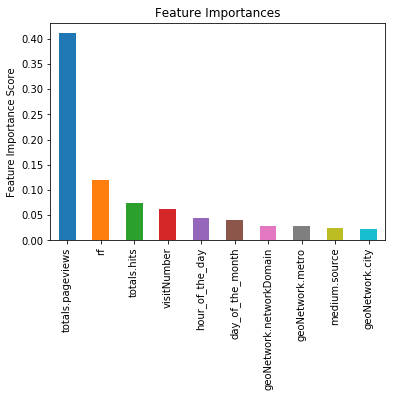

In [91]:
features = X[model_features].columns#[1:10]
importances = gb_reg.feature_importances_#[1:10]
indices = np.argsort(importances)
plt.title('Feature Importance for Gradient Boosting')
feat_imp = pd.Series(gb_reg.feature_importances_, features).sort_values(ascending=False)
feat_imp = feat_imp[0:10]
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.show()

*Note: We can observe that our phase 1 prediction results "rf" and other newly created features such as "hour_of_the_day","day_of_the_month" are among the most important features in our best model*

### Checking if ensemble of results will give better results

In [92]:
test_trans_reg_final['lm_pred'] = np.where(test_trans_reg_final['lm_pred']<0,0,test_trans_reg_final['lm_pred'])
test_trans_reg_final['rf_pred'] = np.where(test_trans_reg_final['rf_pred']<0,0,test_trans_reg_final['rf_pred'])
test_trans_reg_final['gbm_pred'] = np.where(test_trans_reg_final['gbm_pred']<0,0,test_trans_reg_final['gbm_pred'])

test_trans_reg_final['avg_reg'] = (test_trans_reg_final['lm_pred'] + test_trans_reg_final['rf_pred'] + test_trans_reg_final['gbm_pred'])/3.0
print(np.sqrt(metrics.mean_squared_error(np.log1p(test_trans_reg_final['Actuals']),(np.log1p(test_trans_reg_final['avg_reg'])))))

mape=mean_absolute_percentage_error(np.log1p(test_trans_reg_final[test_trans_reg_final.Actuals>0]['Actuals']),(np.log1p(test_trans_reg_final[test_trans_reg_final.Actuals>0]['avg_reg'])))
mape

1.665720451484307


66.09156852848554

*Note: Since Gradient Boosting on it's own gives a better result on the test data when compared to ensemble of all the 3 models, we will proceed with Gradient Boosting predictions for the next business case*

### Saving the phase 2 results

In [93]:
result2 = test_trans_reg_final[test_trans_reg_final['rf']==1]
result2.to_csv("phase2_results.csv",index=False)

## Phase 3 - Customer Lifetime Value Prediction

In [161]:
clv_data = test_trans_reg_final[:]
clv_data['date'] = pd.to_datetime((clv_data['date']), format='%Y%m%d')

In [162]:
cols_for_clv = ['fullVisitorId','date','Actuals','gbm_pred']
clv_data1 = clv_data[cols_for_clv]
clv_data1['gbm_pred'] = np.where(clv_data1['gbm_pred']<0,0.0,clv_data1['gbm_pred'])

In [163]:
clv_data1.head()

,fullVisitorId,date,Actuals,gbm_pred
0,1131660440785968503,2016-09-02,0.0,0.000000
1,27294437909732085,2016-09-02,0.0,0.000834
2,27294437909732085,2016-08-10,0.0,0.000000
3,1905672039242460897,2016-09-02,0.0,0.000000
4,9499785259412240342,2016-09-02,0.0,0.000212


In [164]:
clv_data2 = summary_data_from_transaction_data(clv_data1, 'fullVisitorId', 'date', monetary_value_col='gbm_pred', observation_period_end='2017-08-01')
clv_data2.head()

,frequency,recency,T,monetary_value
fullVisitorId,,,,
4823595352351,0.0,0.0,273.0,0.0
27376579751715,0.0,0.0,171.0,0.0
61609983499251,0.0,0.0,133.0,0.0
62267706107999,0.0,0.0,23.0,0.0
82001414223176,0.0,0.0,244.0,0.0


count    217141.000000
mean          0.155139
std           0.914254
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         119.000000
Name: frequency, dtype: float64
0.9139407113350312


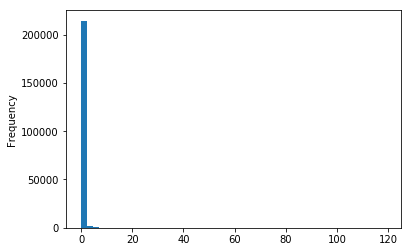

In [165]:
clv_data2['frequency'].plot(kind='hist', bins=50)
print(clv_data2['frequency'].describe())
print(sum(clv_data2['frequency'] == 0)/float(len(clv_data2)))

*Note: Among the 217,141 customers, 91% of the customers made only one purchase*

### First fitting the BetaGeoFitter to account for the frequency and recency of the customer

In [121]:
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(clv_data2['frequency'], clv_data2['recency'], clv_data2['T'])

<lifetimes.BetaGeoFitter: fitted with 217141 subjects, a: 1.52, alpha: 1.00, b: 1.92, r: 0.02>

In [142]:
bgf.save_model('bgf.pkl')

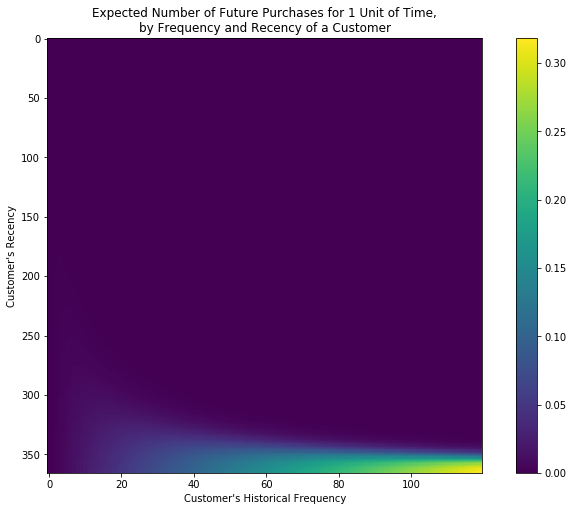

In [169]:
fig = plt.figure(figsize=(12,8))
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.load_model('bgf.pkl')
plot_frequency_recency_matrix(bgf)

*Note: A customer who has Frequency of around 120 with a recency value of 350 is our most profitable/ best customer *
*     A customer who has purchased a lot and most recently is our most important/profitable customer (Bottom right corner) 
*     A customer who has purchased a lot but not recently have probably stopped purchasing/ gone (Top right corner) 
*     There are other customers who buy infrequently (with recency value between 40-300) and we are not sure if these customers are still alive or not and we need to zero-in on that 

### Predicting customers who are surely alive

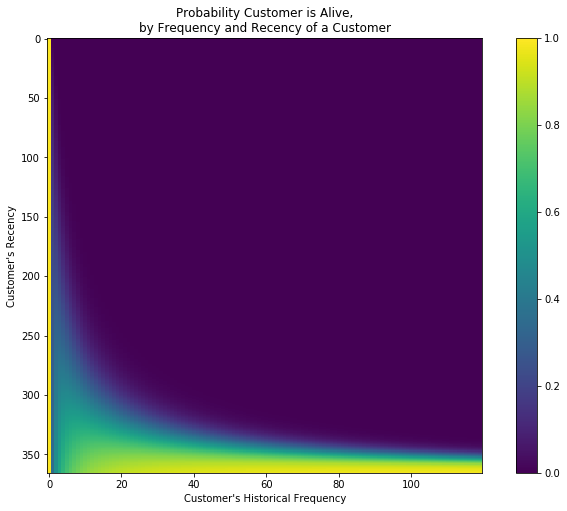

In [170]:
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

*Note: A customer who has purchased recently are surely active customers. Also customers who purchased a lot but not in the recent past are likely to have become inactive. *

### Predicting the number of purchases of the customers over the next 1 year

In [171]:
t = 365
clv_data2['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, clv_data2['frequency'], clv_data2['recency'], clv_data2['T'])
clv_data2.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases
fullVisitorId,,,,,
2319417487130397709,40.0,325.0,328.0,7.983309,18.993694
7445235885559107095,52.0,257.0,258.0,10.540341,27.803317
3937673380007666721,57.0,229.0,230.0,30.438387,31.802254
232377434237234751,47.0,96.0,97.0,1844.742707,32.366937
3269834865385146569,85.0,282.0,285.0,612.283997,42.752254


In [172]:
clv_data2['fullVisitorId'] = clv_data2.index
merge_cols = ['fullVisitorId','rf']
clv_data2 = pd.merge(clv_data2,test_reg[merge_cols],on='fullVisitorId',how='inner')

In [173]:
clv_data3 = clv_data2[clv_data2['rf']==1]
clv_data3.index = clv_data3['fullVisitorId']
clv_data3.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases,fullVisitorId,rf
fullVisitorId,,,,,,,
9467619663210756890,28.0,339.0,347.0,315.886589,12.319991,9467619663210756890,1
3147342618739796829,28.0,209.0,210.0,1.641079,15.964170,3147342618739796829,1
2319417487130397709,40.0,325.0,328.0,7.983309,18.993694,2319417487130397709,1
3937673380007666721,57.0,229.0,230.0,30.438387,31.802254,3937673380007666721,1
232377434237234751,47.0,96.0,97.0,1844.742707,32.366937,232377434237234751,1


### Assessing model fit

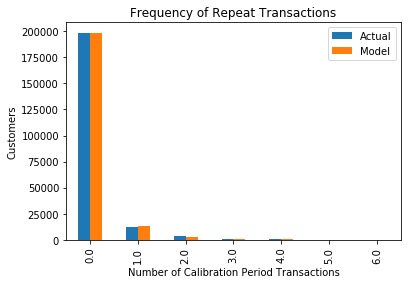

In [174]:
plot_period_transactions(bgf)

### Testing model using hold out data (Last 3 month transactions)

In [175]:
summary_cal_holdout = calibration_and_holdout_data(clv_data1, 'fullVisitorId', 'date',
                                        calibration_period_end='2017-04-30',
                                        observation_period_end='2017-08-01' )   
print(summary_cal_holdout.head())

                frequency_cal  recency_cal  T_cal  frequency_holdout  \
fullVisitorId                                                          
4823595352351             0.0          0.0  180.0                0.0   
27376579751715            0.0          0.0   78.0                0.0   
61609983499251            0.0          0.0   40.0                0.0   
82001414223176            0.0          0.0  151.0                0.0   
90134415725564            0.0          0.0  253.0                0.0   

                duration_holdout  
fullVisitorId                     
4823595352351                 93  
27376579751715                93  
61609983499251                93  
82001414223176                93  
90134415725564                93  


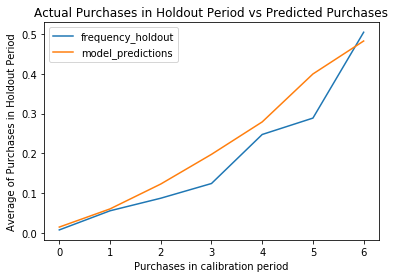

In [176]:
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

### Gamma Gamma Filter

In [177]:
returning_customers_summary = clv_data2[(clv_data2['frequency']>0) & (clv_data2['monetary_value']>0)]
print(returning_customers_summary.head())
print(len(returning_customers_summary))

    frequency  recency      T  monetary_value  predicted_purchases  \
10        6.0     47.0   54.0        0.004417             3.450024   
22        1.0      1.0   16.0        0.020927             0.142843   
27        1.0     24.0   66.0        0.009984             0.294323   
44        1.0     77.0  244.0        0.000974             0.137385   
49        1.0      3.0  196.0        0.006364             0.011001   

      fullVisitorId  rf  
10  170187170673177   0  
22  293088006393965   0  
27  341233254631987   0  
44  485418944539313   0  
49  523898361254604   0  
16853


#### Making sure that there is no correlation between Monetary Value and Frequency

In [178]:
returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.009295
frequency,0.009295,1.000000


In [179]:
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 16853 subjects, p: 3.66, q: 0.26, v: 0.00>


In [180]:
bgf.fit(clv_data2['frequency'], clv_data2['recency'], clv_data2['T'])

clv_data2['clv_value'] = ggf.customer_lifetime_value(
    bgf, 
    clv_data2['frequency'],
    clv_data2['recency'],
    clv_data2['T'],
    clv_data2['monetary_value'],
    time=12, 
    discount_rate=0.01 
)
clv_data2.sort_values(by='clv_value').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases,fullVisitorId,rf,clv_value
154254,4.0,65.0,76.0,1.228400e+06,2.197403,7282058185499112847,1,2.730341e+06
216792,1.0,87.0,291.0,2.007242e+07,0.117159,9725941383382274621,1,2.761122e+06
170941,33.0,243.0,273.0,6.608525e+05,4.576154,8197879643797712877,1,2.885476e+06
207383,1.0,47.0,335.0,4.628426e+07,0.054047,2686617890416738717,1,2.933462e+06
6126,15.0,356.0,361.0,2.695276e+06,6.531559,101246539776970727,1,1.683980e+07


In [181]:
final_data_clv = clv_data2[clv_data2['rf']==1]
final_data_clv = final_data_clv.sort_values(by='clv_value',ascending=False)
final_data_clv.insert(8, 'Customer_Rank', range(1, 1 + len(final_data_clv)))
final_data_clv.head()

,frequency,recency,T,monetary_value,predicted_purchases,fullVisitorId,rf,clv_value,Customer_Rank
6126,15.0,356.0,361.0,2.695276e+06,6.531559,101246539776970727,1,1.683980e+07,1
207383,1.0,47.0,335.0,4.628426e+07,0.054047,2686617890416738717,1,2.933462e+06,2
170941,33.0,243.0,273.0,6.608525e+05,4.576154,8197879643797712877,1,2.885476e+06,3
216792,1.0,87.0,291.0,2.007242e+07,0.117159,9725941383382274621,1,2.761122e+06,4
154254,4.0,65.0,76.0,1.228400e+06,2.197403,7282058185499112847,1,2.730341e+06,5


### Saving the phase 3 results

In [182]:
final_data_clv.to_csv("phase3_results.csv",index=False)

### Getting all the information of our users

In [183]:
req_users = list(final_data_clv['fullVisitorId'])
train_final_features = train_df[train_df['fullVisitorId'].isin(req_users)]
train_final_features.to_csv("raw_features_of_users.csv",index=False)

### Combining all the business case results

In [184]:
group_cols = ['fullVisitorId']
counted = 'gbm_pred'
agg_name = 'Total_Predicted_Revenue'
gp1 = result2[group_cols+[counted]].groupby(group_cols)[counted].sum().reset_index().rename(columns={counted:agg_name})

counted = 'Actuals'
agg_name = 'Total_Actual_Revenue'
gp2 = result2[group_cols+[counted]].groupby(group_cols)[counted].sum().reset_index().rename(columns={counted:agg_name})

In [185]:
#gp3 = gp2[:]
gp3 = pd.merge(gp2,gp1,on='fullVisitorId',how='inner')
gp3 = pd.merge(gp3,result1,on='fullVisitorId',how='inner')
gp3 = pd.merge(gp3,final_data_clv,on='fullVisitorId',how='inner')

In [186]:
gp3 = gp3.sort_values(by='Customer_Rank',ascending=True)
gp3['Actuals'] = np.where(gp3['Actuals']==0,"Non-Revenue Generating Customer","Revenue Generating Customer")
gp3['Predicted'] = np.where(gp3['Predicted']==0,"Non-Revenue Generating Customer","Revenue Generating Customer")
gp3.head(10)

,fullVisitorId,Total_Actual_Revenue,Total_Predicted_Revenue,Actuals,Predicted,frequency,recency,T,monetary_value,predicted_purchases,rf,clv_value,Customer_Rank
254,101246539776970727,2.945800e+08,4.042934e+07,Revenue Generating Customer,Revenue Generating Customer,15.0,356.0,361.0,2.695276e+06,6.531559,1,1.683980e+07,1
9045,2686617890416738717,0.000000e+00,4.628426e+07,Non-Revenue Generating Customer,Revenue Generating Customer,1.0,47.0,335.0,4.628426e+07,0.054047,1,2.933462e+06,2
7374,8197879643797712877,4.034960e+09,2.180838e+07,Revenue Generating Customer,Revenue Generating Customer,33.0,243.0,273.0,6.608525e+05,4.576154,1,2.885476e+06,3
9618,9725941383382274621,1.765500e+09,2.007318e+07,Revenue Generating Customer,Revenue Generating Customer,1.0,87.0,291.0,2.007242e+07,0.117159,1,2.761122e+06,4
6701,7282058185499112847,9.706000e+07,4.913601e+06,Revenue Generating Customer,Revenue Generating Customer,4.0,65.0,76.0,1.228400e+06,2.197403,1,2.730341e+06,5
2867,2402527199731150932,2.333860e+09,1.633261e+08,Revenue Generating Customer,Revenue Generating Customer,23.0,235.0,303.0,7.101134e+06,0.378986,1,2.569835e+06,6
7776,8694856978867122948,7.512000e+07,1.147912e+08,Revenue Generating Customer,Revenue Generating Customer,1.0,8.0,246.0,1.147912e+08,0.017350,1,2.342024e+06,7
1089,608915197735218105,2.838020e+09,4.500180e+06,Revenue Generating Customer,Revenue Generating Customer,13.0,261.0,265.0,3.443686e+05,6.469856,1,2.144066e+06,8
6044,6419312684856935815,0.000000e+00,2.769595e+06,Non-Revenue Generating Customer,Revenue Generating Customer,4.0,52.0,57.0,6.923989e+05,2.615398,1,1.839221e+06,9
3246,2926339495422227598,1.315000e+08,1.408826e+09,Revenue Generating Customer,Revenue Generating Customer,5.0,61.0,271.0,2.817651e+08,0.004743,1,1.315060e+06,10


### Checking the purchase pattern of the most valued customer

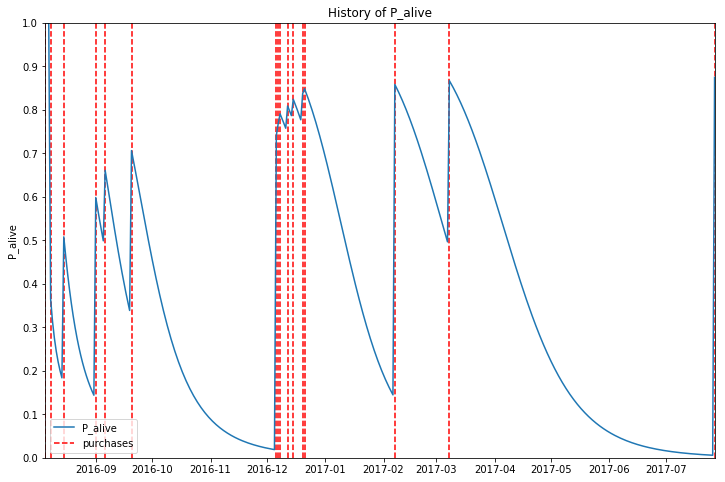

In [187]:
fig = plt.figure(figsize=(12,8))
id = 101246539776970727
days_since_birth = 30
sp_trans = clv_data1.loc[clv_data1['fullVisitorId'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'date')

*Note: Even though this customer is not a frequent visitor, the customer brings in substantial value to the business and the predicted value of the customer for the next 12 months is 16 million. *